# Introduction to Modeling

## What are models?

https://en.wikipedia.org/wiki/Mathematical_model

A model is the use of mathematics as the language to describe a natural or man-made system. Models are used to understand systems and to help make predictions of the system behavior. Great models become Laws (like Newton's Laws or Einstein's Relativity). The key to modeling is to keep it simple, but not too simple.

It is tradition that models are organized as follows:

* Governing equations
* Supplementary sub-models
    * Defining equations
    * Constitutive equations
* Assumptions and constraints
    * Initial and boundary conditions
    * Classical constraints and kinematic equations

There are multiple classifications of Mathematical Models.
https://en.wikipedia.org/wiki/Mathematical_model#Classifications



In the simplest of terms a mathmatical model is just using independent variables (time, location, depth, etc.) to determine dependent variables (location, pressure, volume, etc.).

$$\begin{array}{c}
Dependent\\variable
\end{array} = f\left(\begin{array}{c}
independent\\variable
\end{array}, parameters, \begin{array}{c}
forcing\\functions
\end{array}\right )$$

Dependent variables are characteristic of the system. Independent variables are usually dimensions or time. Parameters are some form of the systems properties. Forcing functions are external influences to the system.


## An example modeling problem

### Newton's 2nd Law of Motion
The force acting on the body $F$ in *Newtons (N)* is equal to the mass $m$ of the body in *kg* times its acceleration $a$ in $m/s^2$

$${F=ma}$$

If we rearrange with get a more desciptive form:

$$a = \frac{F}{m}$$

where $a$ is the dependent variable, $m$ is the parameter reflecting a property of the system, and $F$ is obviously the forcing function.

The model has the following characteristics:
1. It describes a natural process
2. Its an idealization or simplifications (it doesn't include quantum or relativistic corrections)
3. It renders useful and reproducable results that can be used to predict behavior of a system

It is algebraic, so it is super easy to solve. The real fun is when we bring back the Calculus and solve the problem of a *Tom Petty Object* (a free falling body). 

![falling body](fig1.png)

Using the differential form of acceleration (the infinitesimal change of velocity with the change in time)  we can rewrite the 2nd Law as:

$$\frac{dv}{dt}=\frac{F}{m}$$

The next step is a force balance, the force down $F_D$ has to equal the force up $F_U$. The downward force is that of gravity:

$$F_D=mg$$

where g is gravitational constant $9.81m/s^2$ on Earth and assuming down is the "positive" direction. The upward force is slightly more complex and is known as *Drag Force*. For the time being, we will need to create a secondary (constituent) model for drag. We will assume it is linearly proportional to velocity and acts in the upward "negative" direction.

$$F_U=-cv$$

$c$ is the proportionality constant called the *drag coefficient* and is in $kg/s$.

Therefore doing our force balance, we come up with the following equation:

$$\frac{dv}{dt}=\frac{F}{m}=\frac{mg-cv}{m}$$

This can be simplified into the following differential equation:

$$\frac{dv}{dt}=g-\frac{c}{m}v$$

## Solving the Equation
### Symbolic Solutions in Python (Sympy)

#### Call the Sympy library
This line also initiates the "pretty" printing functionality of sympy

In [133]:
import sympy as sym
sym.init_printing()

#### Setup the variables and Build the Function

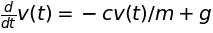

In [134]:
t, m, c, g = sym.symbols('t,m,c,g')
v = sym.Function('v')(t)
dvdt = v.diff(t)
expr = sym.Eq(dvdt,(g-(c/m)*v))
expr

#### Determine what kind of ODE it is (wish this existed when I took DiffEQ)

In [135]:
sym.classify_ode(expr)

('separable',
 '1st_linear',
 'Bernoulli',
 'almost_linear',
 '1st_power_series',
 'lie_group',
 'nth_linear_constant_coeff_undetermined_coefficients',
 'nth_linear_constant_coeff_variation_of_parameters',
 'separable_Integral',
 '1st_linear_Integral',
 'Bernoulli_Integral',
 'almost_linear_Integral',
 'nth_linear_constant_coeff_variation_of_parameters_Integral')

#### Solve for the general expression

In [136]:
soln = sym.dsolve(expr,v)
soln

#### Find the exact solution for initial conditions ($v=0$ at $t = 0$)


In [137]:
ics = [soln.lhs.subs(t,0)- 0,soln.rhs.subs(t,0)-0]
ics

In [138]:
constant = sym.solve(ics)
constant

#### Substitute Coefficient to Find Exact Solution

In [139]:
C1 = sym.symbols('C1')

In [140]:
ext_soln = soln.subs(constant[0])
ext_soln

#### Make it pretty with simplify

In [141]:
sym.simplify(ext_soln)

#### Evaluating for specific values (Substitution)
If the falling object is on Earth ($9.81m/s$), has a mass of $68kg$, and has a drag coefficient of $12.5kg/s$. 

In [142]:
ext_soln_const = ext_soln.subs([(g,9.81),(m,68.),(c,12.5)])

In [143]:
sym.simplify(ext_soln_const)

#### Plotting 

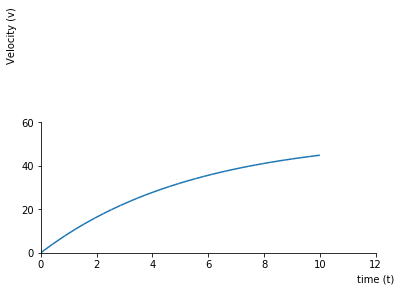

In [144]:
pl = sym.plot(ext_soln_const.rhs,xlim = {0,12}, ylim = {0,100},xlabel = 'time (t)', ylabel = 'Velocity (v)', show=False
)
pl.show()

In [145]:
times = [0,2,4,6,8,10,12,sym.oo]
for time in times:
    print(sym.simplify(ext_soln_const.subs(t,time)))

Eq(v(0), 3.5527136788005e-14)
Eq(v(2), 16.4175591688156)
Eq(v(4), 27.7844450851434)
Eq(v(6), 35.6544392850263)
Eq(v(8), 41.1033202856899)
Eq(v(10), 44.8759157165525)
Eq(v(12), 47.4879155534424)
Eq(v(oo), 53.3664)


### Numerical Solution

We can approximate the Second law derivative using what is known as a *finite difference*, meaning we can compute the slope on ever more refined finite intervals. So an approximation of the derivative is as follows:

$$\frac{dv}{dt}\cong\frac{\Delta v}{\Delta t}=\frac{v(t_{i+1})-v(t_i)}{t_{i+1}-t_i}$$

where $\Delta v$ and $\Delta t$ are the differences in velocity and time computed over finite intervals. This is visualized below.

![finite difference](fig2.png)

Remember your calculus. 

$$\frac{dv}{dt}=\lim_{t \to 0} \frac{\Delta v}{\Delta t}$$

So to best approximate the solution, we would continue to shrink the difference, here called the time step ($\Delta t$) to improve our results. Lets substitute and test it out.

$$\frac{v(t_{i+1})-v(t_i)}{t_{i+1}-t_i}=g-\frac{c}{m}v(t_i)$$

If we rearrange this we get the following:

$$v(t_{i+1})=v(t_i)+\left [g-\frac{c}{m}v(t_i)\right](t_{i+1}-t_i)$$

Now we have an algebraic equation that we can use to solve numerically for the solution. Using the following algorithm:

$$New\space Value = old\space value+slope \times step\space size$$

This is called Euler's Method and we will come back to it later in this course.

In [146]:
def diff(vti,ti,g,c,m,delt):
    ti_1 = ti+delt
    vti_1 = vti+(g-(c/m)*vti)*(ti_1-ti)
    return vti_1 

In [147]:
g= 9.81
c= 12.5
m= 68.0
delt= 2.0
diff(0,0,g,c,m,delt)

In [148]:
times = [0,2,4,6,8,10,12]
delt = 2
velocity = [0,0,0,0,0,0,0,0]
for time in times:
    velocity[times.index(time)+1] = diff(velocity[times.index(time)],time,g,c,m,delt)
    print(time, velocity[times.index(time)])

0 0
2 19.62
4 32.02676470588236
6 39.87221885813149
8 44.833314866171385
10 47.97047851831426
12 49.95427318069872


In [149]:
import numpy as np
times = [0,2,4,6,8,10,12]
delt = 2
velocity = np.zeros(8)
velocity_an = np.zeros(8)
for time in times:
    velocity[times.index(time)+1] = diff(velocity[times.index(time)],time,g,c,m,delt)
    velocity_an[times.index(time)] = sym.simplify(ext_soln_const.subs(t,time)).rhs

velocity_an[len(velocity_an)-1] = sym.simplify(ext_soln_const.subs(t,1000)).rhs
abs_error = np.subtract(velocity, velocity_an)
rel_error = np.divide(abs_error,velocity_an)*100

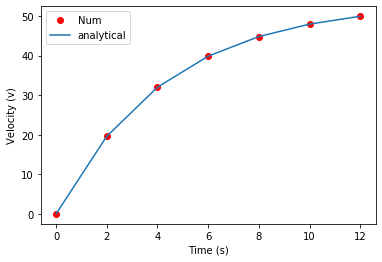

In [150]:
import matplotlib.pyplot as plt
p2 = plt.plot(times,velocity[0:7], 'ro', label = 'Num')
p3 = plt.plot(times,velocity[0:7], label = 'analytical')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (v)')
plt.legend()

In [151]:
import pandas as pd
df = pd.DataFrame ({ 'Num Velocity':np.round(velocity,2), 'Analytical Velocity': np.round(velocity_an,2), 'Abs Error': np.round(abs_error,2), 'Relative Error':np.round(rel_error,2)})
df

,Num Velocity,Analytical Velocity,Abs Error,Relative Error
0,0.00,0.00,-0.00,-100.00
1,19.62,16.42,3.20,19.51
2,32.03,27.78,4.24,15.27
3,39.87,35.65,4.22,11.83
4,44.83,41.10,3.73,9.07
5,47.97,44.88,3.09,6.90
6,49.95,47.49,2.47,5.19
7,51.21,53.37,-2.16,-4.04


In [152]:
# Approxamtion and error (trying to find the effect of decreasing time on the accuracy of the answer)
def diff(t_1,ti,g,c,m,vi):
    v_1 = vi+(g-(c/m)*vi)*(t_1-ti)
    return v_1

In [212]:
#Function
def solver(delta_value,ti,vi,tims,vels):
    t_1 = ti+delta_value
    while ti<=12.:
        v_1 = diff(t_1,ti,vi,g,c,m)
        vi = v_1
        ti = t_1
        vels = np.append(vels,v_1)
        tims = np.append(tims,t_1)
        t_1 = ti+delta_value
        return vels,tims

In [225]:
# Initiate Variables 
vi= 0 
ti = 0
vels = np.append(vels,vi)
tims= np.append (tims,ti)
vels= np.zeros(1)
tims = np.zeros(1)
delta_value = 1
delta_value = 0.1
delta_value = 0.01
delta_value = 0.001

In [226]:
#import numpy as np
#from scipy.optimize import curve_fit
#xdata = np.array(range(0,12))
#ydata = np.array(range(1,3))
#def func(n,a,b,c,d):
 #   return(a+n**b)+2**(c*n+d)

In [231]:
# using Python magic "%" to obtain the real time from the Computer. 
%time vels,tims = solver(delta_value,ti,vi,tims,vels)

CPU times: user 114 µs, sys: 19 µs, total: 133 µs
Wall time: 326 µs


In [232]:
df = pd.DataFrame ({'Velocity':vels,'Time (s)':tims})
df = df.round(4)

In [233]:
# Identify Value of V at 2 seconds
Value_Velocity = df.loc[df['Time (s)'] == 3]['Velocity']

In [234]:
# % Error -> ((Numerical-Analytical)/Analytical)*100
solver(((Value_Velocity) - sym.simplify(ext_soln_const.subs(t,2.)).rhs/sym.simplify(ext_soln_const.subs(t,2.)).rhs)*100)


TypeError: solver() missing 4 required positional arguments: 'ti', 'vi', 'tims', and 'vels'

Text(0, 0.5, 'Error')

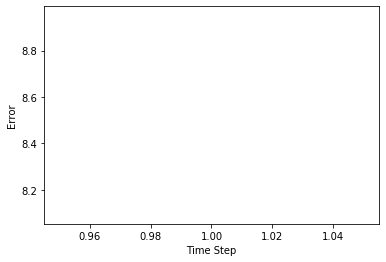

In [235]:
dt = [1.]
err = [8.522]
t_cpu = [4.05E-6]
df2 = pd.DataFrame({'Time_Step':dt,'Error':err,'CPU_Time':t_cpu})

plt.plot(df2.Time_Step,df2.Error)
plt.xlabel('Time Step')
plt.ylabel('Error')

Text(0, 0.5, 'CPU Time')

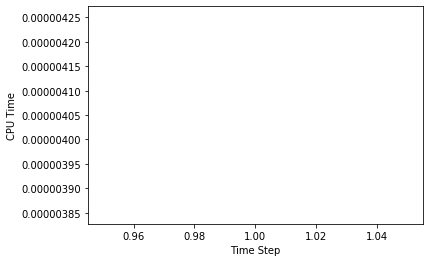

In [236]:
plt.plot(df2.Time_Step,df2.CPU_Time)
plt.xlabel('Time Step')
plt.ylabel('CPU Time')